In [1]:
# import
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

from scipy.optimize import linear_sum_assignment
from shapely import geometry
import matplotlib.patches as mpatches
import pandas as pd
from skimage.transform import resize

import os.path

C:\Users\ojkbe\AppData\Local\Temp/ipykernel_18304/443173674.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [45]:
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [8]:
# directories
base_dir = "C:/Users/ojkbe/Desktop/Master/SEMP/Studium/Machine Learning/ML_Project_2/"
path_tif_dataset = base_dir + "dataset/raw-data/"
path_csv_pred = base_dir + "dataset/single-channel-images/predictions_annotation.csv"
path_csv_groundtruth = base_dir + "dataset/raw-data/annotations.csv" # not needed for the first part

### Load centriole values and choose image

In [12]:
# load csv predictions for centrioles
pred_cen_df = pd.read_csv(path_csv_pred)
# display all possible predictions too choose from
uni_img_names = pred_cen_df.image_name.unique()
print("Choose image from list")
for c, name in enumerate(uni_img_names):
    print("No.", c, "Name", name)

Choose image from list
No. 0 Name RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask
No. 1 Name RPE1wt_CEP63+CETN2+PCNT_1_004_002_max_C3_mask
No. 2 Name RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C1_mask
No. 3 Name RPE1wt_CP110+GTU88+PCNT_2_003_003_max_C1_mask
No. 4 Name RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C1_mask
No. 5 Name RPE1wt_CEP63+CETN2+PCNT_1_002_001_max_C1_mask
No. 6 Name RPE1wt_CEP152+GTU88+PCNT_1_004_002_max_C3_mask
No. 7 Name RPE1wt_CEP63+CETN2+PCNT_1_004_004_max_C3_mask
No. 8 Name RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C3_mask
No. 9 Name RPE1wt_CEP63+CETN2+PCNT_1_000_004_max_C2_mask
No. 10 Name RPE1wt_CP110+GTU88+PCNT_2_004_000_max_C1_mask
No. 11 Name RPE1wt_CEP63+CETN2+PCNT_1_003_001_max_C2_mask
No. 12 Name RPE1wt_CP110+GTU88+PCNT_2_003_004_max_C2_mask
No. 13 Name RPE1wt_CP110+GTU88+PCNT_2_002_003_max_C2_mask
No. 14 Name RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C2_mask
No. 15 Name RPE1wt_CEP152+GTU88+PCNT_1_002_003_max_C1_mask
No. 16 Name RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C

Choose name/image

In [34]:
# choose prediction
cen_pred_name = "RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask"

In [35]:
# get predictions for image
cent_df = pred_cen_df.loc[data['image_name'] == cen_pred_name]
cent_df.head()

,image_name,focus_id,x,y
884,RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask,0,2012,1240
885,RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask,1,1955,847
886,RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask,2,1948,848
887,RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask,3,1893,132
888,RPE1wt_CEP63+CETN2+PCNT_1_000_000_max_C2_mask,4,1883,1505


In [69]:
cen_coord_x = np.array(cent_df["x"])
cen_coord_y = np.array(cent_df["y"])
cen_coord = np.array([cen_coord_x, cen_coord_y])

### Image to infer on

In [78]:
# check for tif image in DAPI channel (nuclei channel)
# get folder
idx = [pos for pos, char in enumerate(cen_pred_name) if char == "_"]
folder = cen_pred_name[0:(idx[2])]
tif_no = cen_pred_name[0:(idx[5])] + "_C0.tif"

tif_path = path_tif_dataset + "/" + folder + "/projections_channel/DAPI/tif/" + tif_no
if os.path.isfile(tif_path):
    pass
else:
    print("Tif does not seem to exists")
    print("With path", tif_path)

# load tif image
X = list(map(imread,glob(tif_path)))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

# define scale
rsz = 256
sc = rsz / X[0].shape[0]
# scale down centrioles
cen_coord_x_sc = cen_coord_x * sc
cen_coord_y_sc = cen_coord_y * sc
    
# resize image as stardist takes 256x256px images
resized_data = resize(X[0], (rsz, rsz))
img = normalize(resized_data, 1,99.8, axis=axis_norm)

Display tif

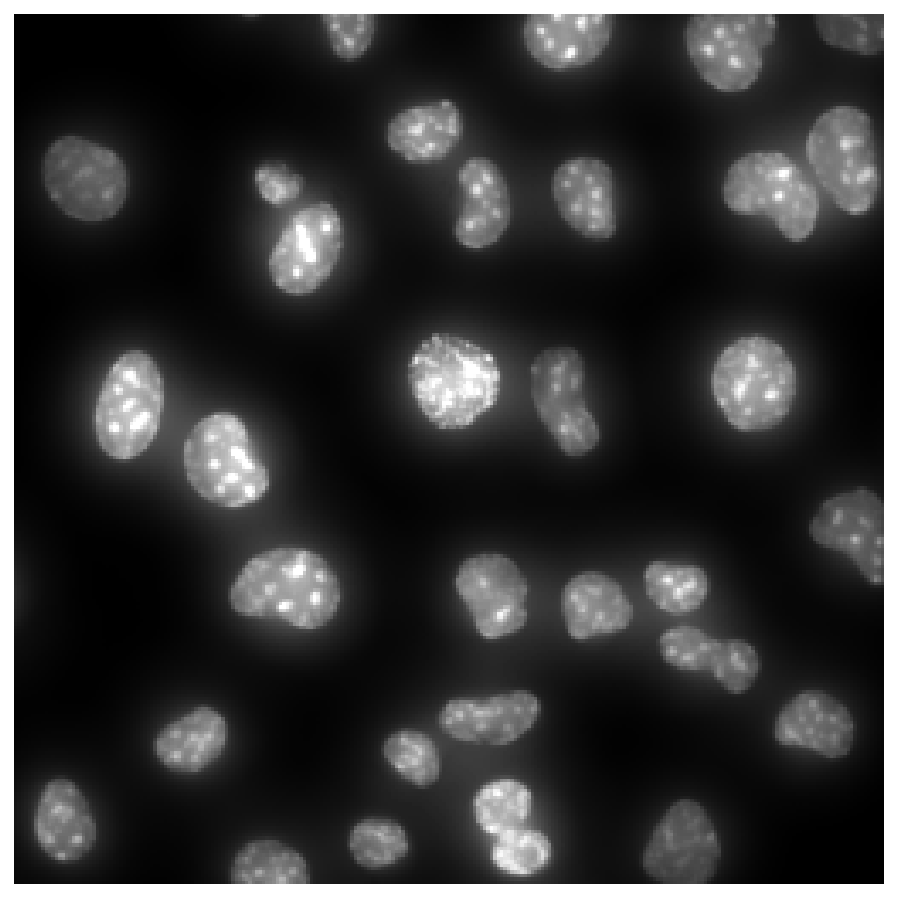

In [37]:
# display tif
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.axis('off');

### Stardist Model

In [38]:
# load stardist model
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


Perform predictions on tif with stardist

In [39]:
# perform stardist on image
labels, details = model.predict_instances(img)

Number of Nuclei: 34


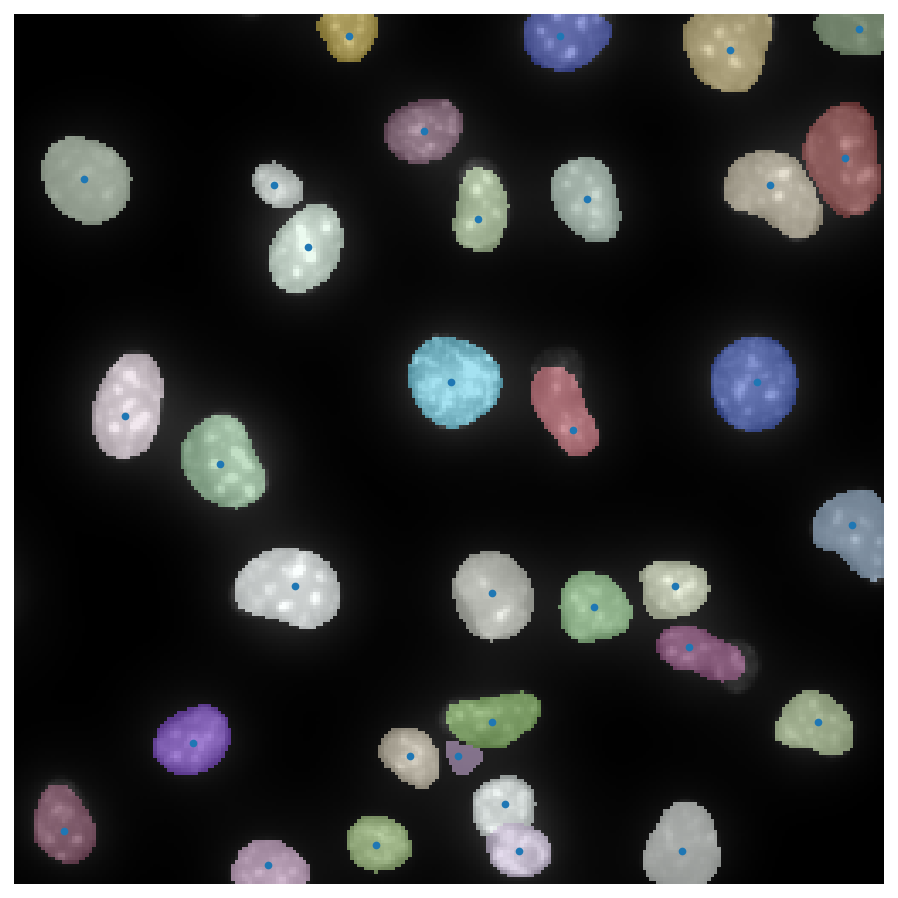

In [50]:
# make predictions more useable 
nuc_center = np.flip(details["points"], -1)
nuc_coord = details["coord"]
print("Number of Nuclei:", nuc_coord.shape[0])
nuc_coord = np.transpose(nuc_coord, axes=(0, 2, 1)) # get points
nuc_coord = np.flip(nuc_coord, -1)

# display nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.axis('off');

Adjust predictions

In [51]:
# (human assisted?!)
# change probability
print("Probalities", details["prob"])

Probalities [0.89088833 0.88666344 0.8857953  0.87670743 0.8753152  0.8652047
 0.8544527  0.8536509  0.85265726 0.8458152  0.84365034 0.8409456
 0.83743167 0.8347063  0.83406293 0.83056784 0.82765675 0.82622606
 0.82265395 0.8152825  0.8145863  0.811605   0.803808   0.8028796
 0.8016276  0.78601444 0.77242225 0.7643076  0.7553251  0.74173033
 0.72611713 0.7253196  0.7163633  0.5250812 ]


In [58]:
prob = 0.65 # maybe check for standard deviation
prob_nuc_coord = nuc_coord[details["prob"] >= prob]
drop_nuc_coord = nuc_coord[details["prob"] < prob]
prob_nuc_center = nuc_center[details["prob"] >= prob]

Display dropped nuclei

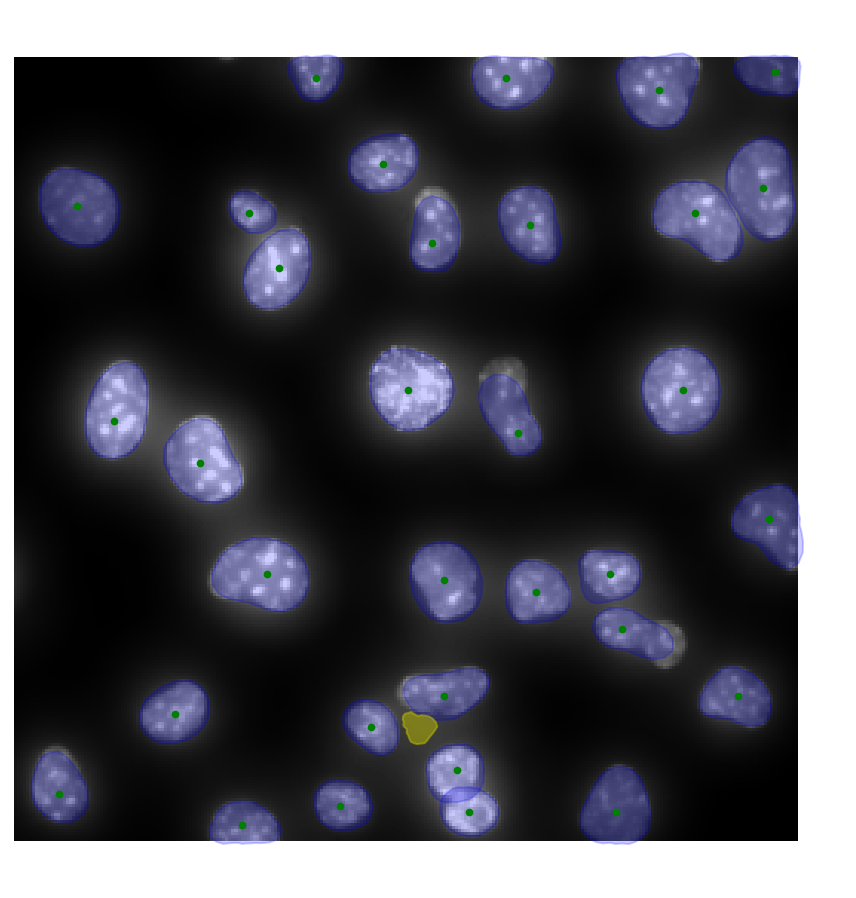

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
for nuc in prob_nuc_coord:
    ax.add_patch(mpatches.Polygon(nuc, color='b', alpha=0.2))
for nuc in drop_nuc_coord:
    ax.add_patch(mpatches.Polygon(nuc, color='y', alpha=0.5))
ax.scatter(prob_nuc_center[...,0], prob_nuc_center[...,1], c="g", s=8, alpha=1)
plt.axis('off');

### Matching

Before matching

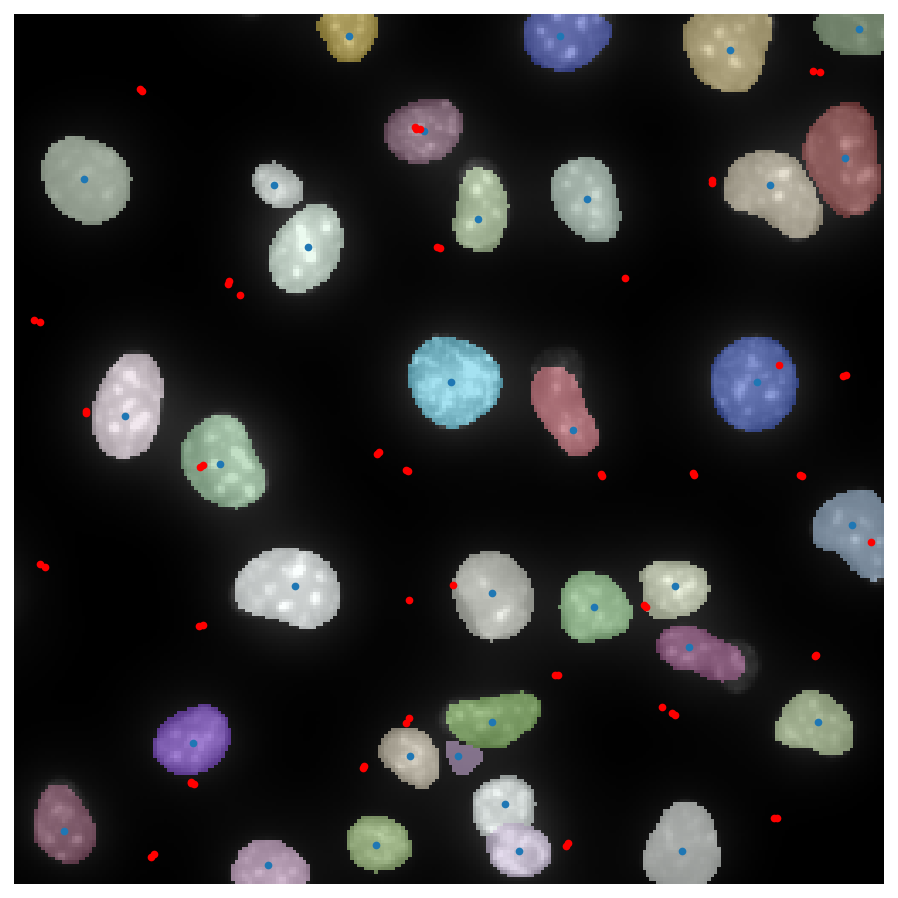

In [79]:
# before matching show centrioles and nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.scatter(cen_coord_x_sc, cen_coord_y_sc, c="r", s=8, alpha=1)
plt.axis('off');

Perform matching

In [91]:
# create ploygons and points
# create distance matrix
C = np.empty([len(list(cen_coord_x_sc)), prob_nuc_coord.shape[0]*4]) # times for because max 4
print("Nuclei no", prob_nuc_coord.shape[0], "Distance matrix", C.shape)

for i, cen in enumerate(zip(cen_coord_x_sc, cen_coord_y_sc)):
    #print("Centriole", i)
    pt = geometry.Point(((cen[0], cen[1])))
    
    for j, nuc in enumerate(prob_nuc_coord):
        #print("Nuclei", j*4, j*4+4)
        poly = geometry.Polygon((tuple(map(tuple, nuc))))
        # print(poly.wkt) # prints: 'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))'

        # The point is in the polygon, so the distance will always be 0.0
        #print("Distance", poly.distance(pt))  # 0.0
        
        dis = poly.distance(pt)
        
        C[i, j*4:(j*4)+4] = dis # for all the nuclei the same

Nuclei no 33 Distance matrix (63, 132)


In [93]:
# perform bipartite matching
row_ind, col_ind = linear_sum_assignment(C)

Delete too far centrioles - Choose threshold distance

In [108]:
# delete centrioles too far away
# threshold distance
# discard those where the distance is too long
# remember centeroile not matched
dis_thres = 30 # on 256x256
del_idx = np.where(C[row_ind, col_ind] > dis_thres)
#np.where(C > dis_thres)
cen_without_match = row_ind[del_idx]

row_ind_del = np.delete(row_ind, del_idx)
col_ind_del = np.delete(col_ind, del_idx)

print("Centrioles which are too far away")
cen_without_match

Centrioles which are too far away


array([59, 60, 61, 62], dtype=int64)

In [109]:
# reduce nuclei back to original numbers
nuc_no = col_ind_del // 4
nuc_uni = np.unique(nuc_no)

In [110]:
print("Centriole matched to Nuclei")
for i in range(0, len(col_ind_del)):
    print("To nuclei", col_ind_del[i] // 4, "was centriole", row_ind_del[i], "matched")

Centriole matched to Nuclei
To nuclei 22 was centriole 0 matched
To nuclei 2 was centriole 1 matched
To nuclei 2 was centriole 2 matched
To nuclei 29 was centriole 3 matched
To nuclei 14 was centriole 4 matched
To nuclei 14 was centriole 5 matched
To nuclei 29 was centriole 6 matched
To nuclei 22 was centriole 7 matched
To nuclei 22 was centriole 8 matched
To nuclei 2 was centriole 9 matched
To nuclei 15 was centriole 10 matched
To nuclei 15 was centriole 11 matched
To nuclei 16 was centriole 12 matched
To nuclei 16 was centriole 13 matched
To nuclei 20 was centriole 14 matched
To nuclei 2 was centriole 15 matched
To nuclei 26 was centriole 16 matched
To nuclei 26 was centriole 17 matched
To nuclei 26 was centriole 18 matched
To nuclei 20 was centriole 19 matched
To nuclei 20 was centriole 20 matched
To nuclei 17 was centriole 21 matched
To nuclei 30 was centriole 22 matched
To nuclei 30 was centriole 23 matched
To nuclei 9 was centriole 24 matched
To nuclei 9 was centriole 25 matched


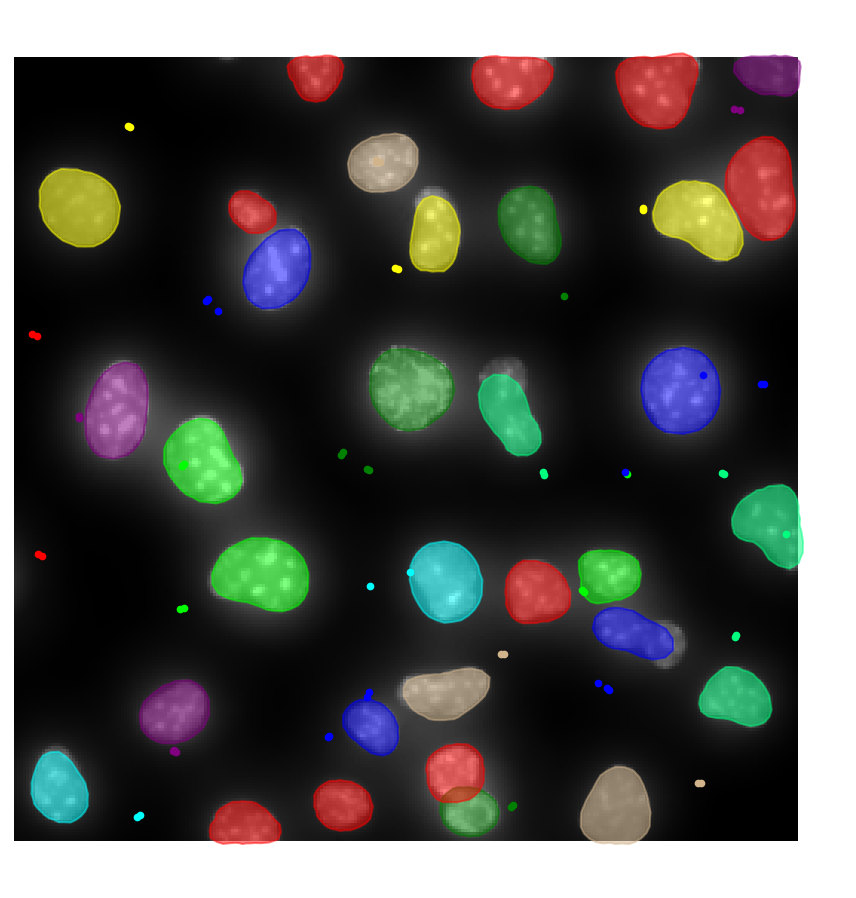

In [115]:
# display matching
color_unmatched = "red"
colors_matched = ['yellow', 'green', 'blue', 'cyan', 'lime', 'purple', 'springgreen', 'tan']

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')

for c, nuc in enumerate(prob_nuc_coord):
    # Nuclei
    if c in nuc_uni:
        # print("match, idx nuc", c)
        # matched nuclei
        ax.add_patch(mpatches.Polygon(nuc, color=colors_matched[c % len(colors_matched)], alpha=0.5))
    else:
        # print("no match, idx nuc", c)
        ax.add_patch(mpatches.Polygon(nuc, color=color_unmatched, alpha=0.5))
    # Nuclei center
    # plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
for c, cen in enumerate(list(cen_coord_x_sc)):
    # Centrioles
    if c in row_ind_del:
        # matched centriole
        # nuclei = col_ind_del[np.where(row_ind_del == c)]
        # print("Match cen", c, "with nuclei", int(nuc_no[np.where(row_ind_del == c)]))
        ax.scatter(cen_coord_x_sc[c], cen_coord_y_sc[c], c=colors_matched[int(nuc_no[np.where(row_ind_del == c)]) % len(colors_matched)], s=8, alpha=1)
    else:
        # print(c)
        ax.scatter(cen_coord_x_sc[c], cen_coord_y_sc[c], c=color_unmatched, s=8, alpha=1)
plt.axis('off');

Save results

In [ ]:
# save results as csv

In [ ]:
# nxgraph

### Groundtruth Comparision

GT: blue, pred: red


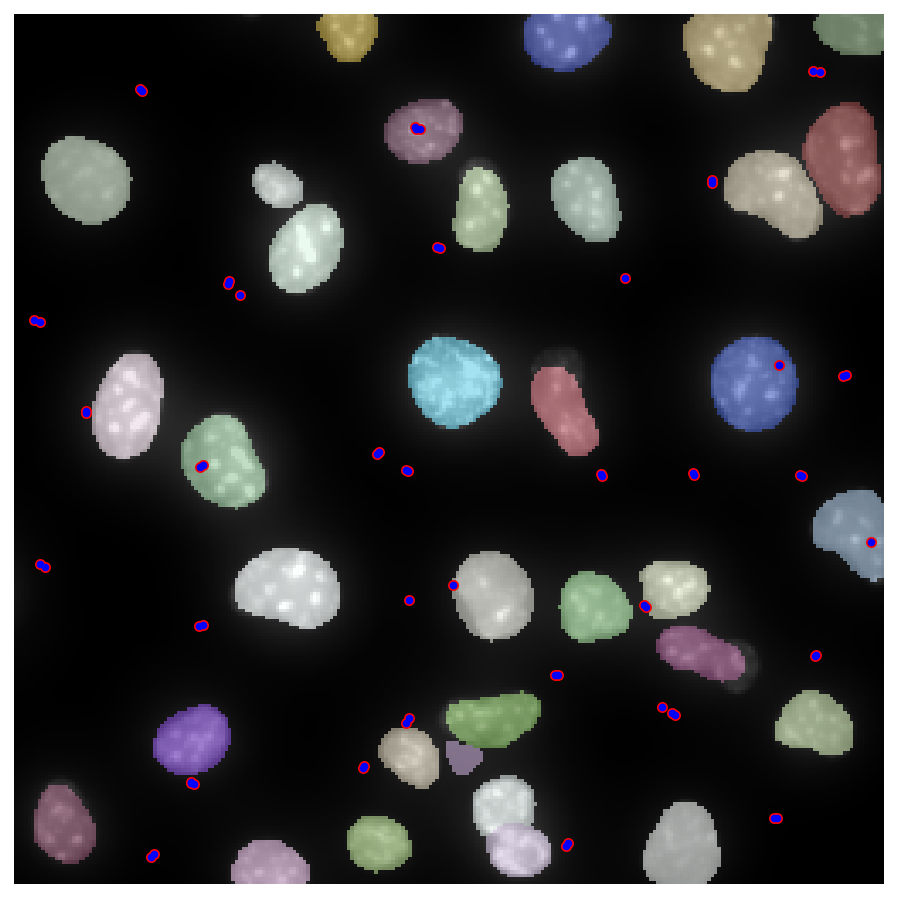

In [87]:
# comparision to groundtruth
# compare centrioles

# load csv GT for centrioles
gt_cen_df = pd.read_csv(path_csv_groundtruth)

# get GT predictions for image
cent_gt_df = pred_cen_df.loc[data['image_name'] == cen_pred_name]

cen_gt_coord_x = np.array(cent_gt_df["x"])
cen_gt_coord_y = np.array(cent_gt_df["y"])
cen_gt_coord = np.array([cen_gt_coord_x, cen_gt_coord_y])

# scale down centrioles
cen_gt_coord_x_sc = cen_gt_coord_x * sc
cen_gt_coord_y_sc = cen_gt_coord_y * sc

# before matching show GT and pred centrioles and nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
#plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.scatter(cen_coord_x_sc, cen_coord_y_sc, c="r", s=20, alpha=1)
plt.scatter(cen_gt_coord_x_sc, cen_gt_coord_y_sc, c="b", s=8, alpha=1)
plt.axis('off');

print("GT: blue, pred: red")

Matching for the GT

Nuclei no 33 Distance matrix (63, 132)
Centrioles which are too far away
[59 60 61 62]
Centriole matched to Nuclei
To nuclei 22 was centriole 0 matched
To nuclei 2 was centriole 1 matched
To nuclei 2 was centriole 2 matched
To nuclei 29 was centriole 3 matched
To nuclei 14 was centriole 4 matched
To nuclei 14 was centriole 5 matched
To nuclei 29 was centriole 6 matched
To nuclei 22 was centriole 7 matched
To nuclei 22 was centriole 8 matched
To nuclei 2 was centriole 9 matched
To nuclei 15 was centriole 10 matched
To nuclei 15 was centriole 11 matched
To nuclei 16 was centriole 12 matched
To nuclei 16 was centriole 13 matched
To nuclei 20 was centriole 14 matched
To nuclei 2 was centriole 15 matched
To nuclei 26 was centriole 16 matched
To nuclei 26 was centriole 17 matched
To nuclei 26 was centriole 18 matched
To nuclei 20 was centriole 19 matched
To nuclei 20 was centriole 20 matched
To nuclei 17 was centriole 21 matched
To nuclei 30 was centriole 22 matched
To nuclei 30 was centriol

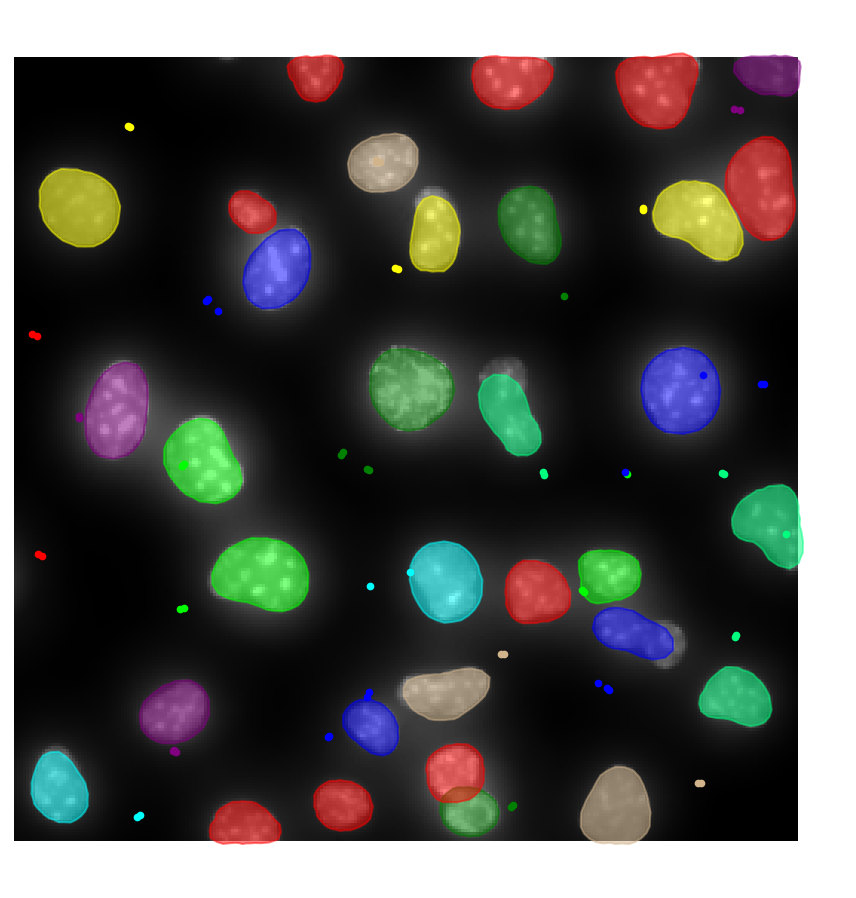

In [117]:
# on GT centrioles same nuclei
# create ploygons and points
# create distance matrix 
C_gt = np.empty([len(list(cen_gt_coord_x_sc)), prob_nuc_coord.shape[0]*4]) # times for because max 4
print("Nuclei no", prob_nuc_coord.shape[0], "Distance matrix", C.shape)

for i, cen in enumerate(zip(cen_gt_coord_x_sc, cen_gt_coord_y_sc)):
    #print("Centriole", i)
    pt = geometry.Point(((cen[0], cen[1])))
    
    for j, nuc in enumerate(prob_nuc_coord):
        #print("Nuclei", j*4, j*4+4)
        poly = geometry.Polygon((tuple(map(tuple, nuc))))
        # print(poly.wkt) # prints: 'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))'

        # The point is in the polygon, so the distance will always be 0.0
        #print("Distance", poly.distance(pt))  # 0.0
        
        dis = poly.distance(pt)
        
        C_gt[i, j*4:(j*4)+4] = dis # for all the nuclei the same

# perform bipartite matching
row_ind_gt, col_ind_gt = linear_sum_assignment(C_gt)

# delete centrioles too far away
# threshold distance
# discard those where the distance is too long
# remember centeroile not matched
dis_thres_gt = 30 # on 256x256
del_idx_gt = np.where(C_gt[row_ind_gt, col_ind_gt] > dis_thres_gt)
#np.where(C > dis_thres)
cen_without_match_gt = row_ind_gt[del_idx_gt]

row_ind_del_gt = np.delete(row_ind_gt, del_idx_gt)
col_ind_del_gt = np.delete(col_ind_gt, del_idx_gt)

print("Centrioles which are too far away")
print(cen_without_match_gt)

# reduce nuclei back to original numbers
nuc_no_gt = col_ind_del_gt // 4
nuc_uni_gt = np.unique(nuc_no_gt)

print("Centriole matched to Nuclei")
for i in range(0, len(col_ind_del_gt)):
    print("To nuclei", col_ind_del_gt[i] // 4, "was centriole", row_ind_del_gt[i], "matched")

# display matching
color_unmatched = "red"
colors_matched = ['yellow', 'green', 'blue', 'cyan', 'lime', 'purple', 'springgreen', 'tan']

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')

for c, nuc in enumerate(prob_nuc_coord):
    # Nuclei
    if c in nuc_uni_gt:
        # print("match, idx nuc", c)
        # matched nuclei
        ax.add_patch(mpatches.Polygon(nuc, color=colors_matched[c % len(colors_matched)], alpha=0.5))
    else:
        # print("no match, idx nuc", c)
        ax.add_patch(mpatches.Polygon(nuc, color=color_unmatched, alpha=0.5))
    # Nuclei center
    # plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
for c, cen in enumerate(list(cen_gt_coord_x_sc)):
    # Centrioles
    if c in row_ind_del_gt:
        # matched centriole
        # nuclei = col_ind_del[np.where(row_ind_del == c)]
        # print("Match cen", c, "with nuclei", int(nuc_no_gt[np.where(row_ind_del == c)]))
        ax.scatter(cen_gt_coord_x_sc[c], cen_gt_coord_y_sc[c], c=colors_matched[int(nuc_no_gt[np.where(row_ind_del == c)]) % len(colors_matched)], s=8, alpha=1)
    else:
        # print(c)
        ax.scatter(cen_gt_coord_x_sc[c], cen_gt_coord_y_sc[c], c=color_unmatched, s=8, alpha=1)
plt.axis('off');

Show if number of assigned centrioles to nucelei are different

In [138]:
nuc_to_cen_gt = []
for l in range(0, len(prob_nuc_coord)):
    nuc_to_cen_gt.append([])

print("GT: Centriole matched to Nuclei")
for i in range(0, len(col_ind_del_gt)):
    # go through the nucelei x 4
    nuc_to_cen_gt[col_ind_del_gt[i] // 4].append(row_ind_del_gt[i])

count_unmatched_nuc_gt = 0
nuc_cen_no_gt = []
for n, c in enumerate(nuc_to_cen_gt):
    if len(c) == 0:
        count_unmatched_nuc_gt += 1
    nuc_cen_no_gt.append(len(c))
    print("To nuclei", n, "number of", nuc_cen_no_gt[-1], "centrioles are matched")
    print("To nuclei", n, "are centrioles", c, "matched")

GT: Centriole matched to Nuclei
To nuclei 0 number of 2 centrioles are matched
To nuclei 0 are centrioles [55, 56] matched
To nuclei 1 number of 4 centrioles are matched
To nuclei 1 are centrioles [36, 38, 39, 40] matched
To nuclei 2 number of 4 centrioles are matched
To nuclei 2 are centrioles [1, 2, 9, 15] matched
To nuclei 3 number of 2 centrioles are matched
To nuclei 3 are centrioles [28, 35] matched
To nuclei 4 number of 2 centrioles are matched
To nuclei 4 are centrioles [46, 49] matched
To nuclei 5 number of 3 centrioles are matched
To nuclei 5 are centrioles [50, 51, 52] matched
To nuclei 6 number of 0 centrioles are matched
To nuclei 6 are centrioles [] matched
To nuclei 7 number of 3 centrioles are matched
To nuclei 7 are centrioles [31, 32, 33] matched
To nuclei 8 number of 0 centrioles are matched
To nuclei 8 are centrioles [] matched
To nuclei 9 number of 2 centrioles are matched
To nuclei 9 are centrioles [24, 25] matched
To nuclei 10 number of 3 centrioles are matched
T

In [139]:
nuc_to_cen = []
for l in range(0, len(prob_nuc_coord)):
    nuc_to_cen.append([])

print("Pred: Centriole matched to Nuclei")
for i in range(0, len(col_ind_del)):
    # go through the nucelei x 4
    nuc_to_cen[col_ind_del[i] // 4].append(row_ind_del[i])

count_unmatched_nuc = 0
nuc_cen_no = []
for n, c in enumerate(nuc_to_cen):
    if len(c) == 0:
        count_unmatched_nuc += 1
    nuc_cen_no.append(len(c))
    print("To nuclei", n, "number of", nuc_cen_no[-1], "centrioles are matched")
    print("To nuclei", n, "are centrioles", c, "matched")

Pred: Centriole matched to Nuclei
To nuclei 0 number of 2 centrioles are matched
To nuclei 0 are centrioles [55, 56] matched
To nuclei 1 number of 4 centrioles are matched
To nuclei 1 are centrioles [36, 38, 39, 40] matched
To nuclei 2 number of 4 centrioles are matched
To nuclei 2 are centrioles [1, 2, 9, 15] matched
To nuclei 3 number of 2 centrioles are matched
To nuclei 3 are centrioles [28, 35] matched
To nuclei 4 number of 2 centrioles are matched
To nuclei 4 are centrioles [46, 49] matched
To nuclei 5 number of 3 centrioles are matched
To nuclei 5 are centrioles [50, 51, 52] matched
To nuclei 6 number of 0 centrioles are matched
To nuclei 6 are centrioles [] matched
To nuclei 7 number of 3 centrioles are matched
To nuclei 7 are centrioles [31, 32, 33] matched
To nuclei 8 number of 0 centrioles are matched
To nuclei 8 are centrioles [] matched
To nuclei 9 number of 2 centrioles are matched
To nuclei 9 are centrioles [24, 25] matched
To nuclei 10 number of 3 centrioles are matched

Comparision

In [140]:
for n in range(0, len(nuc_cen_no)):
    # going through nuclei
    if nuc_cen_no[n] != nuc_cen_no_gt[n]:
        print("For Nuclei", n, "there are different numbers of centrioles assigned")